In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import spacy
import csv
import nltk
import matplotlib.pyplot as plt
import warnings
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.decomposition import PCA,TruncatedSVD,NMF
from sklearn import svm
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve,confusion_matrix, f1_score
from nltk.corpus import stopwords
from autocorrect import Speller
from matplotlib import pyplot as plt
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
from collections import Counter,Counter,defaultdict
from scipy.linalg import svd
from sklearn.tree import DecisionTreeClassifier
spell = Speller(lang='en')
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")


# Importing data and EDA:

In [2]:
df_original_data = pd.read_csv('Hotel_Reviews.csv')
df_all_data = df_original_data.copy()

feature engineering: getting Countries Column  from hotel address columns:

In [3]:
def get_contries():
    df_all_data['Country'] = df_all_data.Hotel_Address.apply(lambda x: str(x).split(" ")[-1])
    df_all_data['Country'] = df_all_data['Country'].str.replace('Kingdom','United Kingdom')
get_contries()

In [4]:
df_all_data

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,Country
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,Netherlands
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,Netherlands
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968,Netherlands
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968,Netherlands
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/30/2015,8.1,Atlantis Hotel Vienna,Kuwait,no trolly or staff to help you take the lugga...,14,2823,location,2,8,7.0,"[' Leisure trip ', ' Family with older childre...",704 day,48.203745,16.335677,Austria
515734,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/22/2015,8.1,Atlantis Hotel Vienna,Estonia,The hotel looks like 3 but surely not 4,11,2823,Breakfast was ok and we got earlier check in,11,12,5.8,"[' Leisure trip ', ' Family with young childre...",712 day,48.203745,16.335677,Austria
515735,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/19/2015,8.1,Atlantis Hotel Vienna,Egypt,The ac was useless It was a hot week in vienn...,19,2823,No Positive,0,3,2.5,"[' Leisure trip ', ' Family with older childre...",715 day,48.203745,16.335677,Austria
515736,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/17/2015,8.1,Atlantis Hotel Vienna,Mexico,No Negative,0,2823,The rooms are enormous and really comfortable...,25,3,8.8,"[' Leisure trip ', ' Group ', ' Standard Tripl...",717 day,48.203745,16.335677,Austria


In [5]:
df_all_data['Country'].unique()

array(['Netherlands', 'United Kingdom', 'France', 'Spain', 'Italy',
       'Austria'], dtype=object)

In [6]:
df_all_data['Country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: Country, dtype: int64

Dividing Data into two parts, positive reviews and negative reviews:

In [7]:
df_pos = df_all_data[['Positive_Review','Hotel_Name','Country','Reviewer_Score','Reviewer_Nationality']]
df_neg = df_all_data[['Negative_Review','Hotel_Name','Country','Reviewer_Score','Reviewer_Nationality']]
df_recom = df_all_data[['Reviewer_Nationality','Hotel_Name','Reviewer_Score']]

Renaming columns from ('Positive_Review''Negative_Review') to Review

In [8]:
df_pos.rename(columns = {'Positive_Review':'Review'},inplace= True)
df_neg.rename(columns = {'Negative_Review':'Review'},inplace= True)

Making new Column named Sentiment and assigning 1 to positive review and 0 to negative review

In [9]:
df_pos['Sentiment'] = 1
df_neg['Sentiment'] = 0
df_all = pd.concat([df_pos,df_neg],ignore_index=True)
df_drop = df_all.drop_duplicates()

data contain non english letters. code below removes all non english reviews 

In [10]:
df_drop = df_drop[df_drop['Review'].map(lambda x: x.isascii())]

Extra Data cleaning such as removing punctuation, repeated_chars etc...

In [11]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
repeated_chars = lambda x: re.sub('(.)\\1{2,}', '\\1', x)
df_drop['Review'] = df_drop.Review.map(alphanumeric).map(punc_lower).map(repeated_chars)
df_drop

,Review,Hotel_Name,Country,Reviewer_Score,Reviewer_Nationality,Sentiment
0,only the park outside of the hotel was beauti...,Hotel Arena,Netherlands,2.9,Russia,1
1,no real complaints the hotel was great great ...,Hotel Arena,Netherlands,7.5,Ireland,1
2,location was good and staff were ok it is cut...,Hotel Arena,Netherlands,7.1,Australia,1
3,great location in nice surroundings the bar a...,Hotel Arena,Netherlands,3.8,United Kingdom,1
4,amazing location and building romantic setting,Hotel Arena,Netherlands,6.7,New Zealand,1
...,...,...,...,...,...,...
1031471,no trolly or staff to help you take the lugga...,Atlantis Hotel Vienna,Austria,7.0,Kuwait,0
1031472,the hotel looks like but surely not,Atlantis Hotel Vienna,Austria,5.8,Estonia,0
1031473,the ac was useless it was a hot week in vienn...,Atlantis Hotel Vienna,Austria,2.5,Egypt,0
1031474,no negative,Atlantis Hotel Vienna,Austria,8.8,Mexico,0


Data contain over 700,000. taking data sample is necessary. We started from 5000 sample till 100,000. After 100,000  we  noticed that the model is not improving nor changing. So, 100,000 is enough to work on 

In [13]:
data_sample = df_drop.sample(100000,random_state=2021)

In [ ]:
data_sample['Review'] = data_sample['Review'].map(lambda x: spell(x))

In [15]:
file = open('data100000', 'rb')
data_sample = pickle.load(file)
file.close()

In [17]:
df_drop

,Review,Hotel_Name,Country,Reviewer_Score,Reviewer_Nationality,Sentiment
0,only the park outside of the hotel was beauti...,Hotel Arena,Netherlands,2.9,Russia,1
1,no real complaints the hotel was great great ...,Hotel Arena,Netherlands,7.5,Ireland,1
2,location was good and staff were ok it is cut...,Hotel Arena,Netherlands,7.1,Australia,1
3,great location in nice surroundings the bar a...,Hotel Arena,Netherlands,3.8,United Kingdom,1
4,amazing location and building romantic setting,Hotel Arena,Netherlands,6.7,New Zealand,1
...,...,...,...,...,...,...
1031471,no trolly or staff to help you take the lugga...,Atlantis Hotel Vienna,Austria,7.0,Kuwait,0
1031472,the hotel looks like but surely not,Atlantis Hotel Vienna,Austria,5.8,Estonia,0
1031473,the ac was useless it was a hot week in vienn...,Atlantis Hotel Vienna,Austria,2.5,Egypt,0
1031474,no negative,Atlantis Hotel Vienna,Austria,8.8,Mexico,0


In [20]:
data_sample

,Review,Hotel_Name,Country,Reviewer_Score,Reviewer_Nationality,Sentiment
198260,friendly staff good service overall clean rooms,Radisson Blu Edwardian New Providence Wharf,United Kingdom,9.6,United Kingdom,1
378853,no positive,Leonardo Hotel Vienna,Austria,8.3,Romania,1
602911,very iverpriced,First Hotel Paris Tour Eiffel,France,5.0,Australia,0
746579,room was very dated and cramped not exactly r...,Radisson Blu Edwardian Vanderbilt,United Kingdom,9.6,United Kingdom,0
939234,no sauna,Golden Tulip Amsterdam Riverside,Netherlands,7.9,United Kingdom,0
...,...,...,...,...,...,...
425668,bed was large and comfortable rooms were basi...,Ilunion Barcelona,Spain,7.9,United Kingdom,1
623105,pool not open gym not open terrace bar not op...,Montcalm Royal London House City of London,United Kingdom,5.0,United Kingdom,0
27847,bed location,The Grosvenor,United Kingdom,9.2,Netherlands,1
669263,that i don t live at the hotel,Courthouse Hotel Shoreditch,United Kingdom,9.6,,0


Tokenizing and lemmatizing reviews

In [21]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

data_sample['text_lemmatized'] = data_sample.Review.apply(lemmatize_text)

In [22]:
data_sample['Joined_text_lemmatize'] =  data_sample['text_lemmatized'].apply(lambda x: ' '.join(x))

In [23]:
nlp = spacy.load('en_core_web_sm')
data_sample['spacy_doc'] = list(nlp.pipe(data_sample.Joined_text_lemmatize))
data_sample

,Review,Hotel_Name,Country,Reviewer_Score,Reviewer_Nationality,Sentiment,text_lemmatized,Joined_text_lemmatize,spacy_doc
198260,friendly staff good service overall clean rooms,Radisson Blu Edwardian New Providence Wharf,United Kingdom,9.6,United Kingdom,1,"[friendly, staff, good, service, overall, clea...",friendly staff good service overall clean room,"(friendly, staff, good, service, overall, clea..."
378853,no positive,Leonardo Hotel Vienna,Austria,8.3,Romania,1,"[no, positive]",no positive,"(no, positive)"
602911,very iverpriced,First Hotel Paris Tour Eiffel,France,5.0,Australia,0,"[very, iverpriced]",very iverpriced,"(very, iverpriced)"
746579,room was very dated and cramped not exactly r...,Radisson Blu Edwardian Vanderbilt,United Kingdom,9.6,United Kingdom,0,"[room, wa, very, dated, and, cramped, not, exa...",room wa very dated and cramped not exactly rom...,"(room, wa, very, dated, and, cramped, not, exa..."
939234,no sauna,Golden Tulip Amsterdam Riverside,Netherlands,7.9,United Kingdom,0,"[no, sauna]",no sauna,"(no, sauna)"
...,...,...,...,...,...,...,...,...,...
425668,bed was large and comfortable rooms were basi...,Ilunion Barcelona,Spain,7.9,United Kingdom,1,"[bed, wa, large, and, comfortable, room, were,...",bed wa large and comfortable room were basic b...,"(bed, wa, large, and, comfortable, room, were,..."
623105,pool not open gym not open terrace bar not op...,Montcalm Royal London House City of London,United Kingdom,5.0,United Kingdom,0,"[pool, not, open, gym, not, open, terrace, bar...",pool not open gym not open terrace bar not ope...,"(pool, not, open, gym, not, open, terrace, bar..."
27847,bed location,The Grosvenor,United Kingdom,9.2,Netherlands,1,"[bed, location]",bed location,"(bed, location)"
669263,that i don t live at the hotel,Courthouse Hotel Shoreditch,United Kingdom,9.6,,0,"[that, i, don, t, live, at, the, hotel]",that i don t live at the hotel,"(that, i, don, t, live, at, the, hotel)"


# Topicing

In [28]:
Positive = open('wordpo', 'rb')
Negative = open('wordne', 'rb')
wordss = pickle.load(Positive)
words_neg = pickle.load(Negative)
Positive.close()
Negative.close()

In [25]:
positive_reviews = data_sample[data_sample.Sentiment==1]
negative_reviews = data_sample[data_sample.Sentiment==0]

In [26]:
sam_pos_df = positive_reviews.copy()
sam_neg_df = negative_reviews.copy()

In [27]:
sam_pos_df['Review'] = sam_pos_df['Review'].str.replace("hotel" , "")
sam_neg_df['Review'] = sam_neg_df['Review'].str.replace("hotel" , "")

## WordCloud for Positive Reviews:

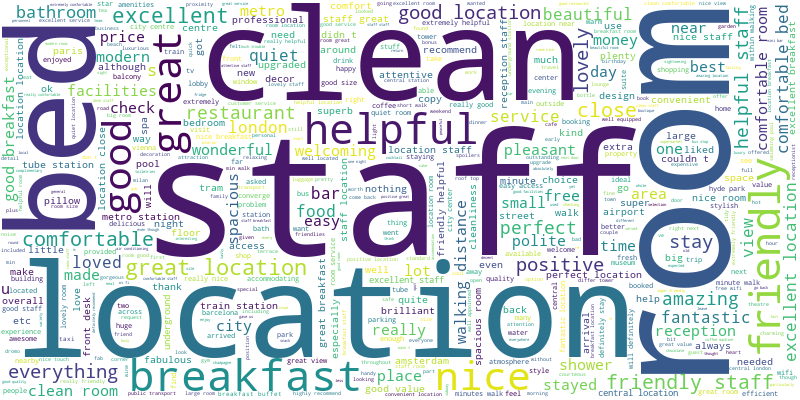

In [29]:
from wordcloud import WordCloud

long_string = ','.join(list(sam_pos_df['Review'].values))
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue', width=800, height=400)
wordcloud.generate(long_string)
wordcloud.to_image()

## WordCloud for Negative Reviews:

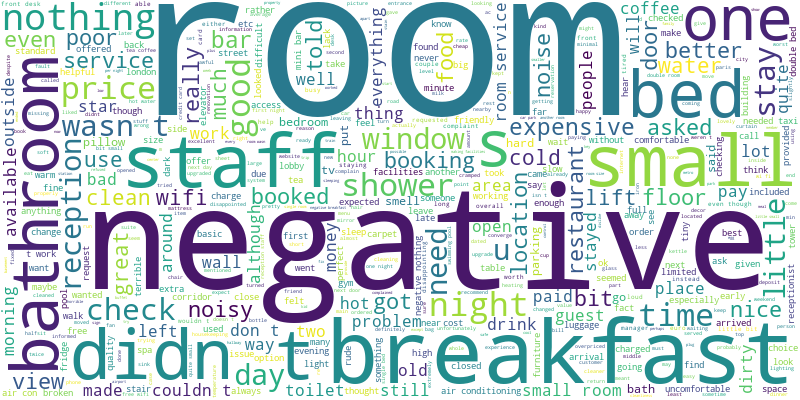

In [31]:
long_string = ','.join(list(sam_neg_df['Review'].values))
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue', width=800, height=400)
wordcloud.generate(long_string)
wordcloud.to_image()

In [32]:
pos_adj = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_ =='ADJ']
neg_adj = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='ADJ']

pos_noun = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='NOUN']
neg_noun = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_ == 'NOUN']

In [33]:
print('Positive Adjective: ',Counter(pos_adj).most_common(5))
print('Negative Adjective: ',Counter(neg_adj).most_common(5))
print('Positive Noun: ',Counter(pos_noun).most_common(5))
print('Negative Noun: ',Counter(neg_noun).most_common(5))

Positive Adjective:  [('good', 11569), ('great', 11182), ('friendly', 9474), ('helpful', 8437), ('nice', 7277)]
Negative Adjective:  [('negative', 6378), ('small', 5228), ('little', 2351), ('good', 2078), ('expensive', 1738)]
Positive Noun:  [('staff', 20879), ('location', 20624), ('room', 19406), ('hotel', 13632), ('breakfast', 9273)]
Negative Noun:  [('room', 22061), ('hotel', 8428), ('breakfast', 6269), ('staff', 4218), ('bed', 4006)]


In [34]:
ENGLISH_STOP_WORDS = stopwords.words('english')

taking stop words from stopwords library and adding extra stop words:

In [35]:
stop_words = text.ENGLISH_STOP_WORDS.union(['didnt','did','havent', 'week', 'hi','wa','ha','day','today','really','also',
                                            'go', 'us', 'dont', 'got', 'im', 'ive','burger','food' ,'came', 'back',
                                           'get','try', 'would', 'time','good','great','service','didn','definitely','hotel','went','took','left',
                                            'check','told','asked','like','don','wasn','hotels','just','don','said','people','ve','stay','stayed',
                                           'loved','com','night','birthday','free','touch','little','given','making','hear','recommend','card','make',
                                           'feel','days','differ','thier','couldn','breakfast'])

In [36]:
vectorizer = CountVectorizer(stop_words=wordss)
doc_word = vectorizer.fit_transform(positive_reviews['Joined_text_lemmatize'])
doc_word.shape

(53634, 10120)

In [37]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [38]:
example = positive_reviews['Joined_text_lemmatize']

### LSA Topicing

In [39]:
lsa = TruncatedSVD(3)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.05824249, 0.04503644, 0.0364302 ])

In [40]:
display_topics(lsa, vectorizer.get_feature_names(),10)


Topic  0
room, staff, location, helpful, clean, nice, comfortable, excellent, bed, lovely

Topic  1
room, bed, comfortable, clean, nice, bathroom, spacious, view, big, small

Topic  2
location, room, station, perfect, close, central, walk, excellent, near, tube


### NMF Topicing

In [41]:
nmf_model = NMF(4)
doc_topic = nmf_model.fit_transform(doc_word)

In [42]:
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
room, comfortable, clean, bed, lovely, bathroom, spacious, view, quiet, small

Topic  1
staff, helpful, excellent, lovely, clean, reception, extremely, restaurant, bar, comfortable

Topic  2
location, excellent, perfect, station, close, central, walk, near, tube, london

Topic  3
nice, station, close, bed, restaurant, walk, metro, area, minute, clean


In [43]:
Vt = pd.DataFrame(doc_topic.round(5),
             index = example,
             columns = ["Room_Condition","Staff",'Station','Area'])
Vt

,Room_Condition,Staff,Station,Area
Joined_text_lemmatize,,,,
friendly staff good service overall clean room,0.07506,0.08137,0.00000,0.00000
no positive,0.00004,0.00007,0.00006,0.00005
the design are beautiful staff are friendly atmosphere is comfortable good location,0.01102,0.08344,0.08419,0.00000
the bed wa super pillow were fab great night s sleep,0.01292,0.00301,0.00000,0.01293
everything wa perfect,0.00173,0.00113,0.00659,0.00000
...,...,...,...,...
no positive,0.00004,0.00007,0.00006,0.00005
very pleasant surprised with this hotel room are so comfortable clean and modern we felt a if we got a lot for the price despite being in a busy area gothic quarter we were never disturbed by street noise we were literally facing barcelona cathedral a soon a we stepped outside the hotel what a beautiful view every morning the pool area on the top floor is also a lovely little outdoor space with nice view loved our stay here,0.11478,0.01526,0.00196,0.14125
a modern hotel in a very central location with wonderful stuff,0.00224,0.00000,0.08957,0.00117


## Corecx Topicing

### Topicing on Positive Reviews

In [44]:
vectorizer = CountVectorizer(ngram_range=(1,2),max_features=2000,
                            stop_words=wordss,token_pattern='\\b[a-z][a-z]+\\b',
                            binary=True)
doc_word = vectorizer.fit_transform(positive_reviews['Review'])
words = list(np.asarray(vectorizer.get_feature_names()))

In [45]:
topic_model = ct.Corex(n_hidden=3, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=positive_reviews)
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: station,close,walk,metro,walking,tube,distance,near,walking distance,easy
1: room,comfortable,clean,bed,rooms,spacious,positive,bathroom,nice,staff
2: bar,coffee,tea,reception,water,restaurant,pool,complimentary,park,arrival


### Topicing on Negative Reviews

In [46]:
vectorizer = CountVectorizer(ngram_range=(1,3),max_features=2000,
                            stop_words=words_neg,token_pattern='\\b[a-z][a-z]+\\b',
                            binary=True)
doc_word = vectorizer.fit_transform(negative_reviews['Review'])
words = list(np.asarray(vectorizer.get_feature_names()))

In [47]:
topic_model = ct.Corex(n_hidden=5, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=negative_reviews)
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: staff,reception,rude,morning,arrived,pay,early,paid,desk,checked
1: bathroom,negative,shower,floor,hot,water,old,rooms,bath,cold
2: air,door,conditioning,air conditioning,far,walk,outside,city,station,sleep
3: breakfast,coffee,tea,bar,price,expensive,tea coffee,money,restaurant,poor
4: room,small,bed,room small,double,small room,size,beds,tiny,single


# Clustring 

In [48]:
def cluster(df):
    for i in df:
        lat = i['lat'].unique()
        lng = i['lng'].unique()
        loc = []
        for f, b in zip(lat, lng):
            loc.append([f,b])
        confert =pd.DataFrame(loc)
        confert.dropna(inplace=True)
        lat = confert[0].tolist()
        lng = confert[1].tolist()
        loc = []
        for f, b in zip(lat,lng):
            loc.append([f,b])

        X = StandardScaler().fit_transform(loc)
        db = DBSCAN(eps=0.15, min_samples=3).fit(X)

        # Let's find the observations DBSCAN called "core"
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        unique_labels = set(labels)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        plt.figure(dpi=200)
        show_core = True
        show_non_core = True
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = 'k'

            class_member_mask = (labels == k)
            if show_core:
                xy = X[class_member_mask & core_samples_mask]
                x, y = xy[:,0], xy[:,1]
                plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1) # add black border for core points

            if show_non_core:
                xy = X[class_member_mask & ~core_samples_mask]
                x, y = xy[:,0], xy[:,1]
                plt.scatter(x, y, c=col, s=20, linewidths=1.1)

        plt.title('Estimated number of clusters: %d' % n_clusters_);

In [49]:
list_of_country_df = []
for i in range(len(df_all_data['Country'].value_counts().index)):
    list_of_country_df.append(df_all_data[(df_all_data["Country"] == df_all_data['Country'].value_counts().index[i])])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

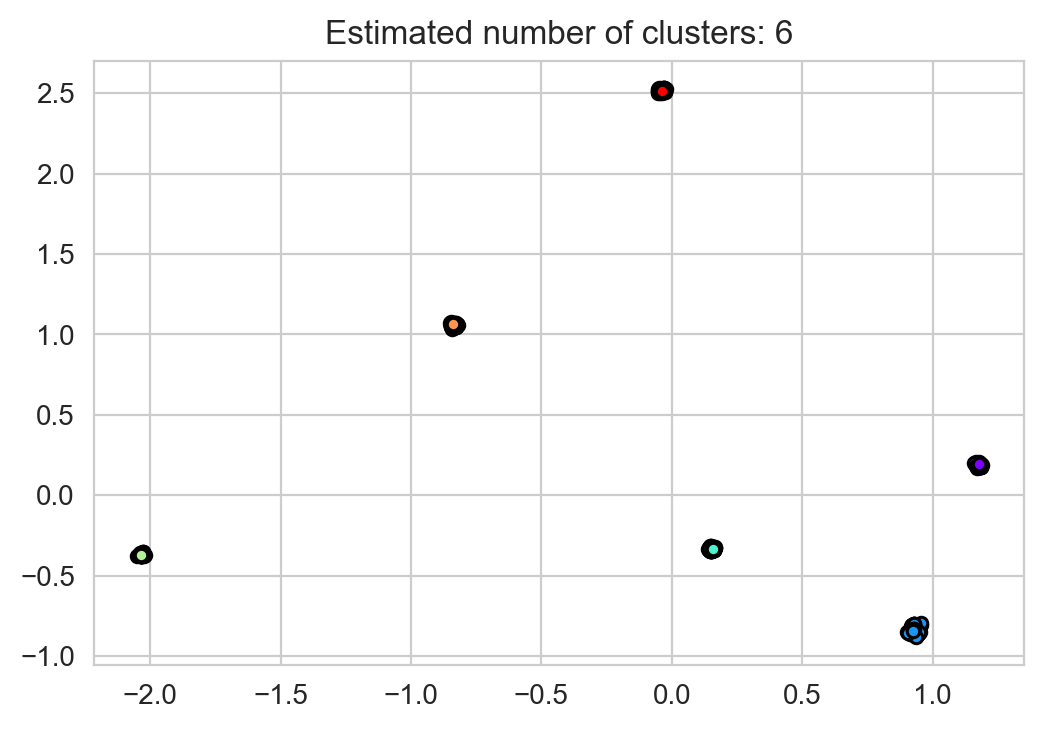

In [50]:
cluster([df_all_data])

### Cluster for hotels location in each country

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

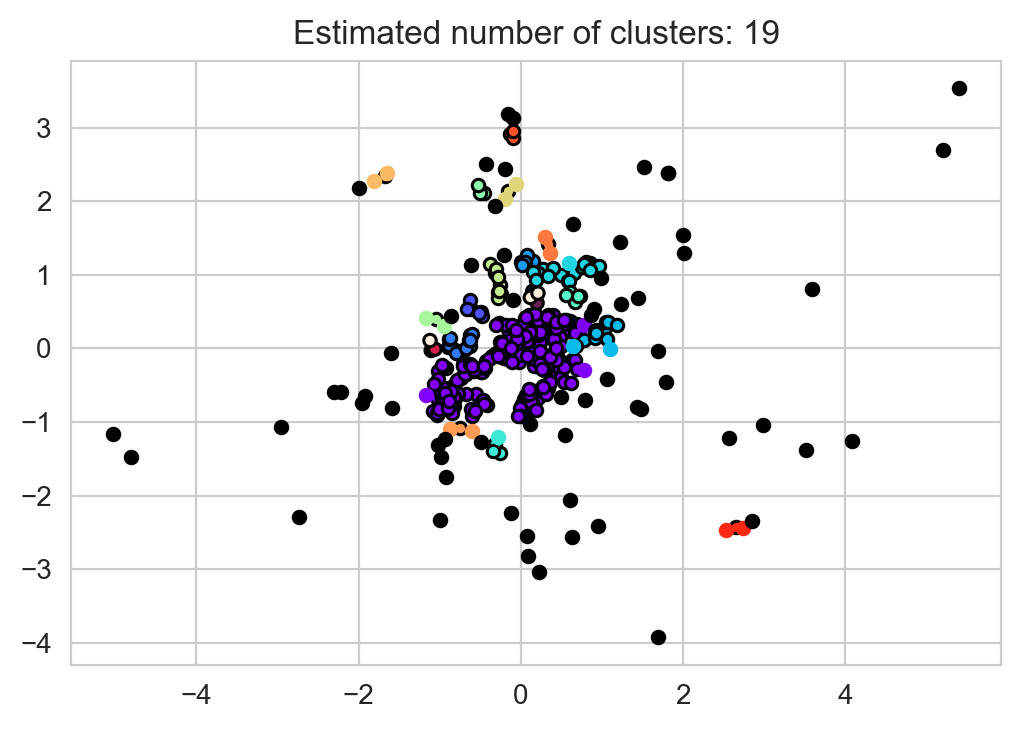

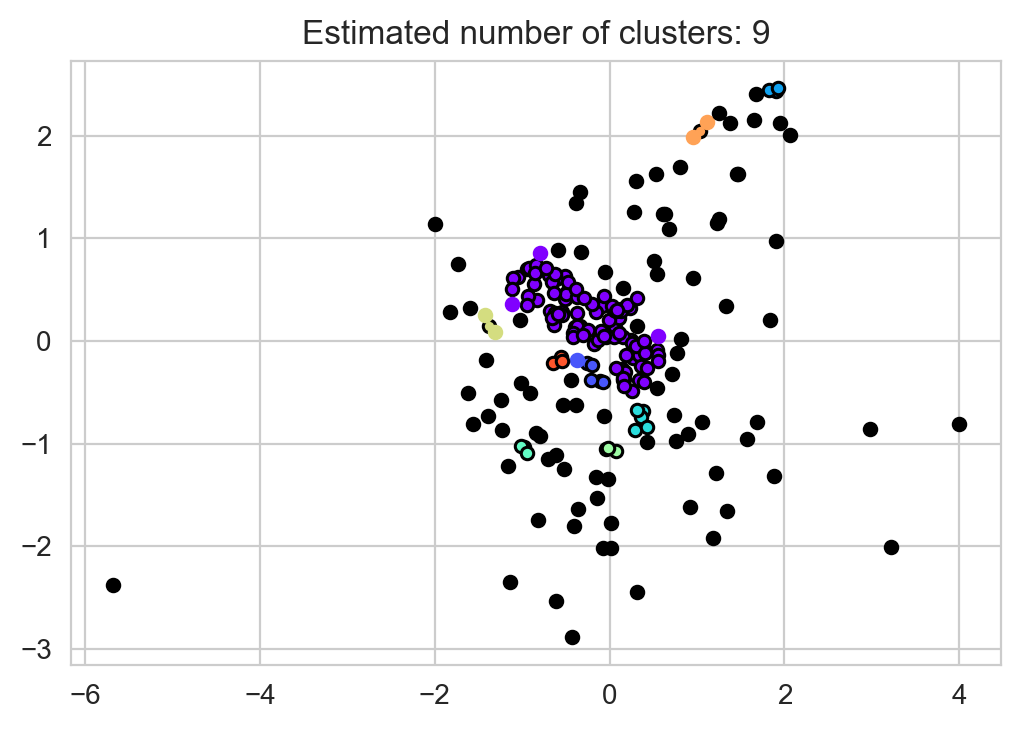

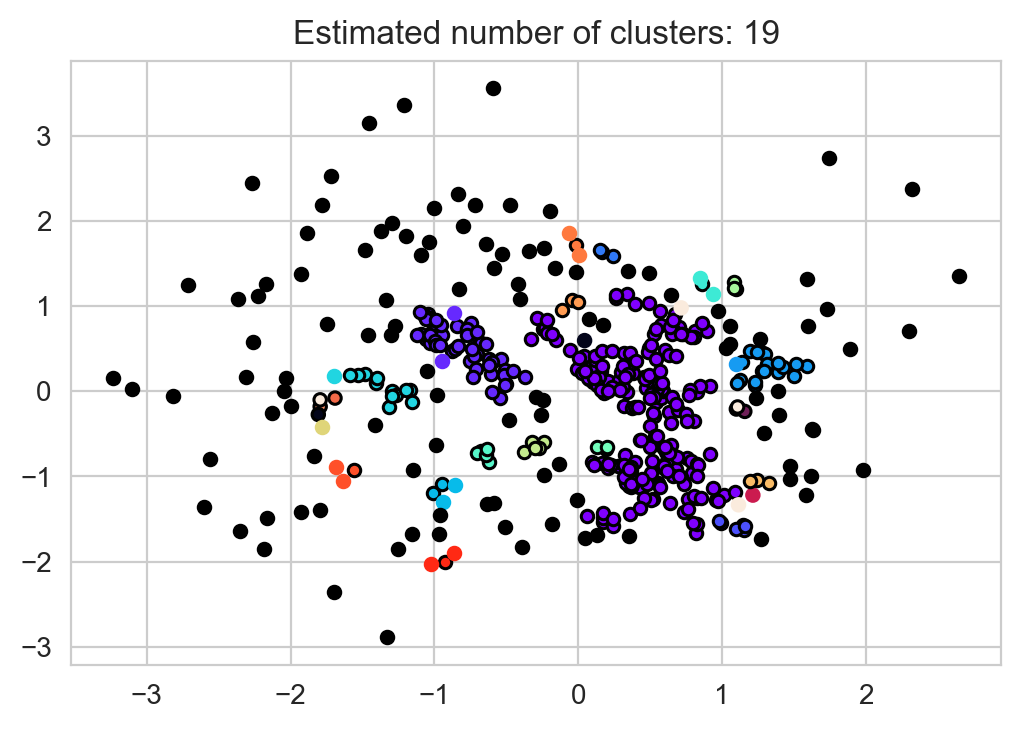

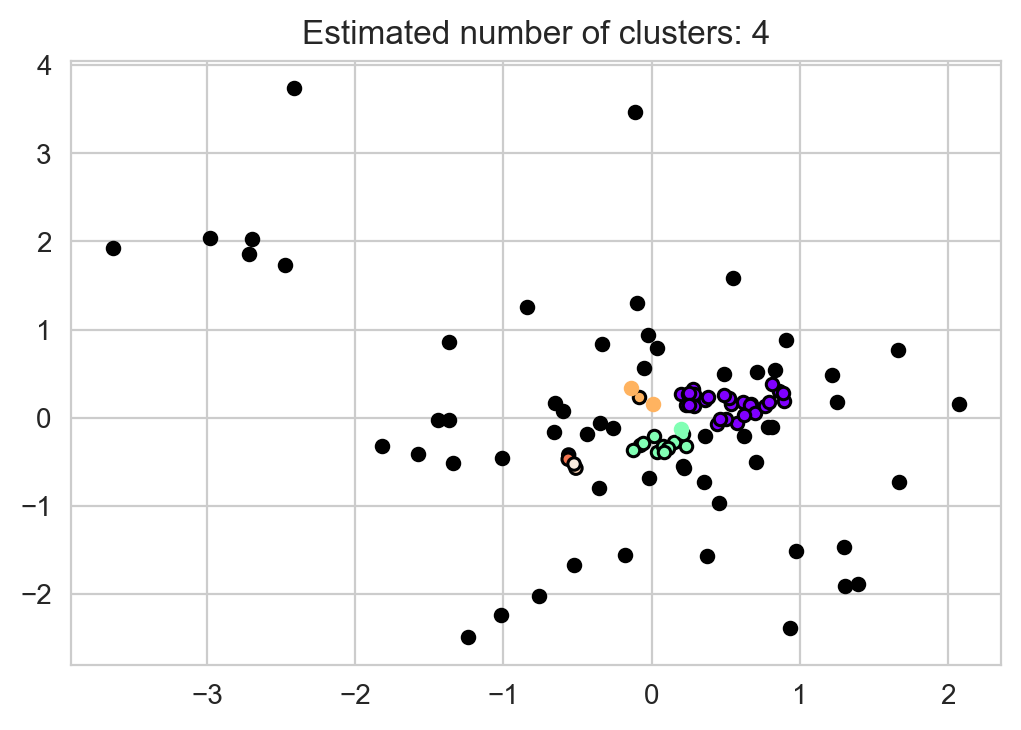

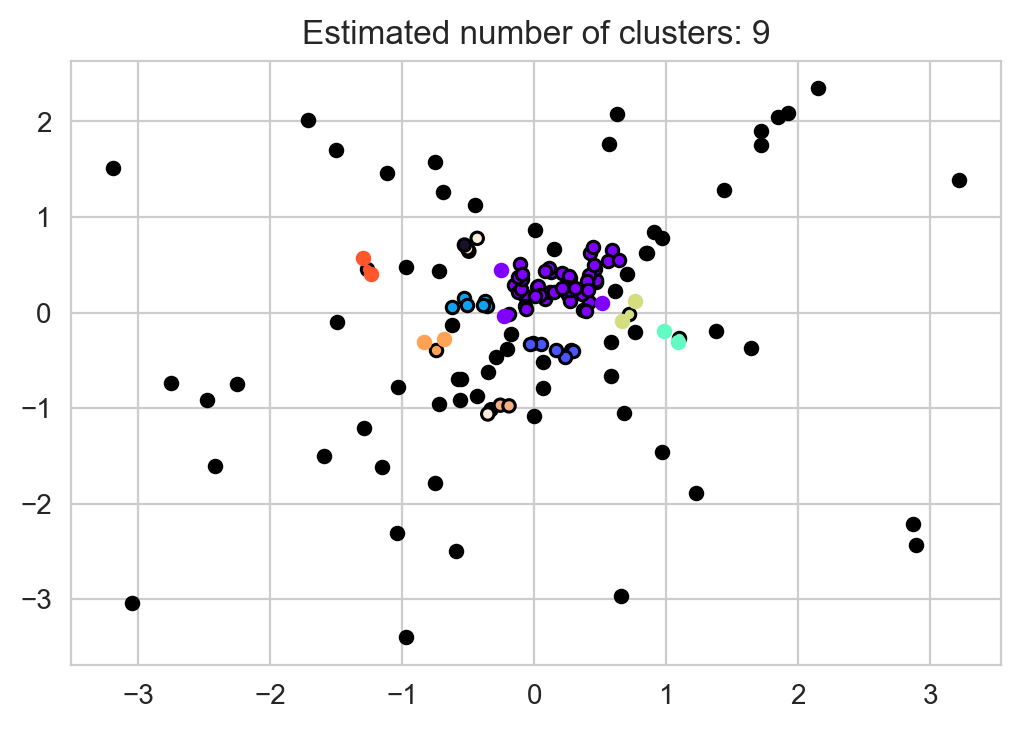

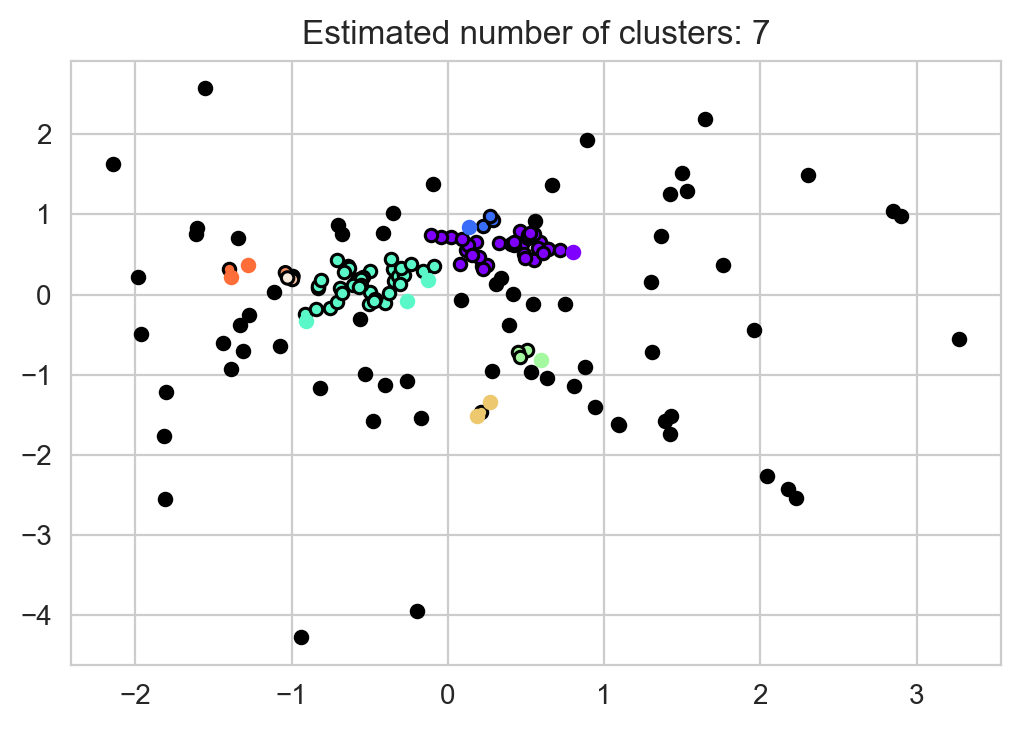

In [51]:
cluster(list_of_country_df)

# SVD Recommndation System

In [52]:
df_recommand = data_sample

In [53]:
df_reco = df_all_data[["Reviewer_Nationality" , "Hotel_Name" , "Reviewer_Score","Country"]]
df_reco

,Reviewer_Nationality,Hotel_Name,Reviewer_Score,Country
0,Russia,Hotel Arena,2.9,Netherlands
1,Ireland,Hotel Arena,7.5,Netherlands
2,Australia,Hotel Arena,7.1,Netherlands
3,United Kingdom,Hotel Arena,3.8,Netherlands
4,New Zealand,Hotel Arena,6.7,Netherlands
...,...,...,...,...
515733,Kuwait,Atlantis Hotel Vienna,7.0,Austria
515734,Estonia,Atlantis Hotel Vienna,5.8,Austria
515735,Egypt,Atlantis Hotel Vienna,2.5,Austria
515736,Mexico,Atlantis Hotel Vienna,8.8,Austria


In [54]:
df_reco = df_reco[df_reco["Reviewer_Nationality"] != " "]
df_reco.Reviewer_Nationality = df_reco.Reviewer_Nationality.str.strip()

In [55]:
df_reco['Country'].value_counts().index

Index(['United Kingdom', 'Spain', 'France', 'Netherlands', 'Austria', 'Italy'], dtype='object')

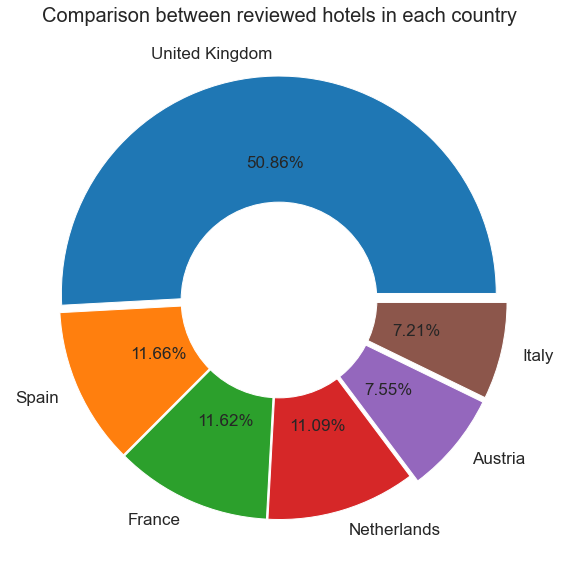

In [56]:
plt.figure(figsize=(10,10))
plt.pie(x=df_reco['Country'].value_counts(),labels=list(df_reco['Country'].value_counts().index)
        ,autopct='%.2f%%',textprops={'fontsize': 17},explode=[0.03,0.01,0.01,0.01,0.05,0.05])
plt.title('Comparison between reviewed hotels in each country',fontdict={'fontsize':20})

centre_circle = plt.Circle((0,0),0.45,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)



plt.show()

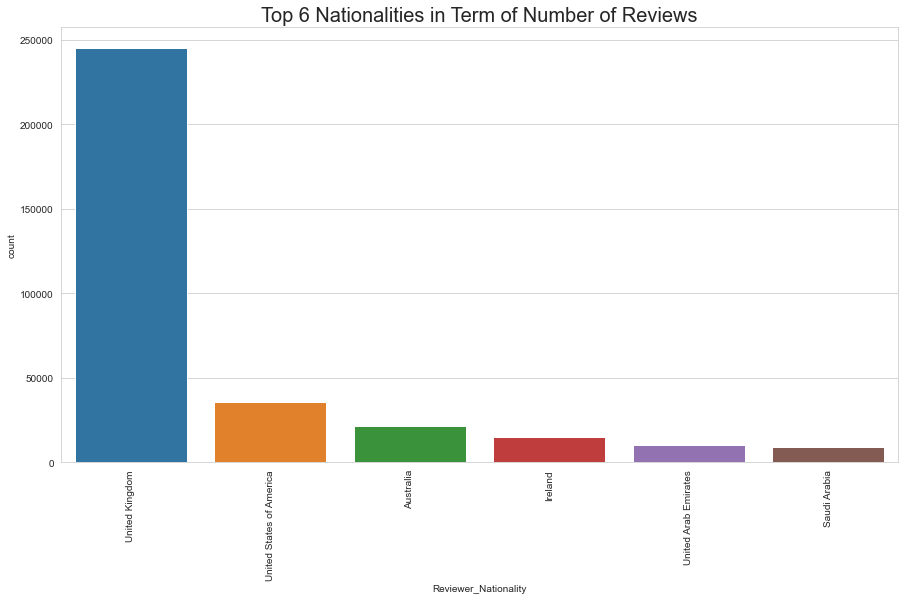

In [57]:
df_top_6 = df_reco[(df_reco['Reviewer_Nationality'] == "United Kingdom") | (df_reco['Reviewer_Nationality'] == "United States of America") |(df_reco['Reviewer_Nationality'] == "Australia") | (df_reco['Reviewer_Nationality'] == "Ireland") |(df_reco['Reviewer_Nationality'] == "United Arab Emirates") | (df_reco['Reviewer_Nationality'] == "Saudi Arabia")]
plt.figure(figsize=(15,8))
sns.countplot(x='Reviewer_Nationality',data=df_top_6 ,order = df_top_6['Reviewer_Nationality'].value_counts().index)
plt.title('Top 6 Nationalities in Term of Number of Reviews',fontdict={'fontsize':20})
plt.xticks(rotation=90);

In [58]:
df_high_all = df_reco[(df_reco["Reviewer_Score"] >= 8)]
df_high_all

,Reviewer_Nationality,Hotel_Name,Reviewer_Score,Country
7,United Kingdom,Hotel Arena,10.0,Netherlands
10,United Kingdom,Hotel Arena,10.0,Netherlands
13,Italy,Hotel Arena,9.2,Netherlands
14,Canada,Hotel Arena,8.8,Netherlands
15,Italy,Hotel Arena,10.0,Netherlands
...,...,...,...,...
515724,India,Atlantis Hotel Vienna,8.3,Austria
515729,Brazil,Atlantis Hotel Vienna,10.0,Austria
515732,Kuwait,Atlantis Hotel Vienna,10.0,Austria
515736,Mexico,Atlantis Hotel Vienna,8.8,Austria


In [59]:
df_reco['Country'].value_counts().index

Index(['United Kingdom', 'Spain', 'France', 'Netherlands', 'Austria', 'Italy'], dtype='object')

In [60]:
list_of_country_df = []
for i in range(len(df_reco['Country'].value_counts().index)):
    list_of_country_df.append(df_high_all[(df_high_all["Country"] == df_reco['Country'].value_counts().index[i])])
    list_of_country_df[i] = list_of_country_df[i][["Reviewer_Nationality" , "Hotel_Name"]]
    list_of_country_df[i] = pd.get_dummies(list_of_country_df[i] , columns =["Hotel_Name"])
    list_of_country_df[i] = list_of_country_df[i].drop_duplicates()
    list_of_country_df[i] = list_of_country_df[i].groupby("Reviewer_Nationality").sum()

In [61]:
def plot_3D_reco(df):
    U, Sigma, VT = svd(df)
    plt.style.use('seaborn')

    fig = plt.figure(figsize=(20,16))
    ax = fig.gca(projection='3d')
    ax.scatter(U[:,0],U[:,1],U[:,2],c='k',s=150);
    ax.set_xlabel("D1", fontsize=20, labelpad=20)
    ax.set_ylabel("D2", fontsize=20, labelpad=20)
    ax.set_zlabel("D3", fontsize=20, labelpad=20);

    lbls = df.index
    offset = 0.02
    for i, txt in enumerate(lbls):
        if i not in [6,7]:
            ax.text(U[i,0]+offset,U[i,1],U[i,2],txt, fontsize=20)
        else:
            ax.text(U[i,0]+offset,U[i,1],U[i,2]+5*offset,txt, fontsize=20)

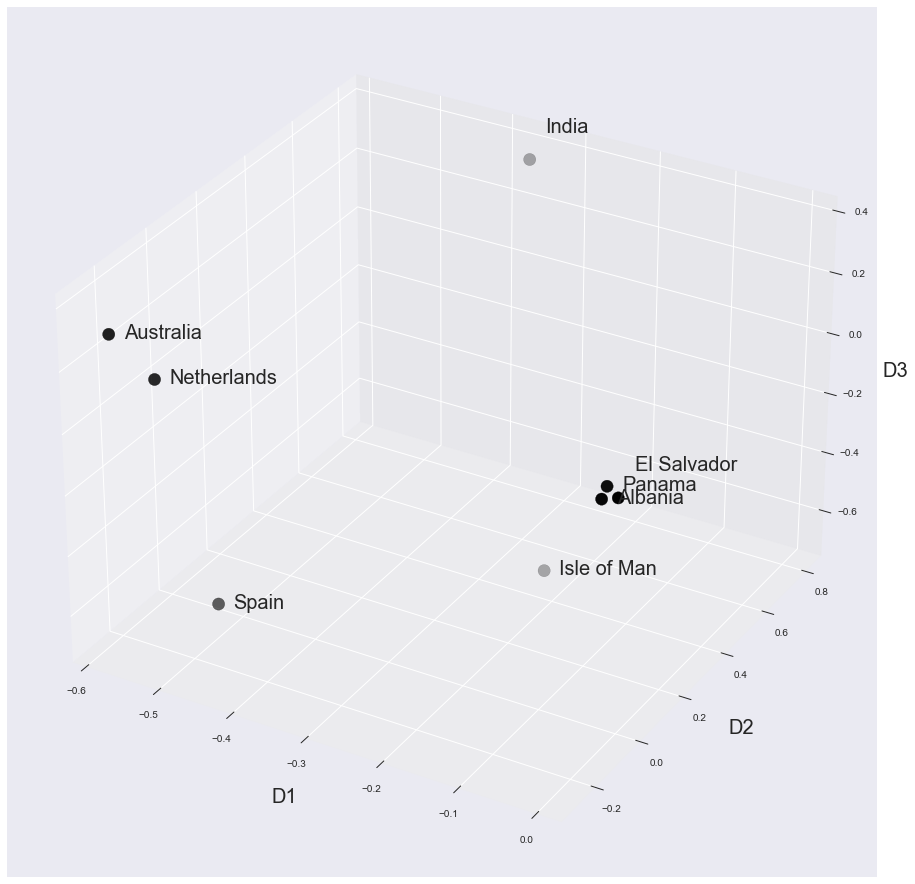

In [64]:
plot_3D_reco(list_of_country_df[0].sample(8))

In [65]:
def get_recommends_user(userID, df ,Nationalities , Hotels):
    U, Sigma, VT = svd(df)
    userrecs = []
    for user in range(U.shape[0]):
        if user!= userID:
            userrecs.append([user,np.dot(U[userID],U[user])])
    final_rec = [i[0] for i in sorted(userrecs,key=lambda x: x[1],reverse=True)]
    comp_user = final_rec[0]
    print("Users from %s are most similar to users from %s."% (User_Nationality_list[userID], User_Nationality_list[comp_user]))
    rec_likes = df.iloc[comp_user]
    current = df.iloc[userID]
    recs = []
    for i,item in enumerate(current):
        if item != rec_likes[i] and rec_likes[i]!=0:
            recs.append(i)
    return recs

In [79]:
user_nation = 'Saudi Arabia'
#user_nation = input("Enter Country Name ")
print("=========People from %s========= "%user_nation )

i = 0
for df in list_of_country_df:
    print("\n\n===Recommended hotels in %s==="%df_reco['Country'].value_counts().index[i])
    User_Nationality_list = df.index
    Hotel_names_list = df.columns.str.replace("Hotel_Name_", "")
    user_nation_index = list(df.index).index(user_nation)
    recommended_hotels = get_recommends_user(user_nation_index,df,
                                             User_Nationality_list,Hotel_names_list)


    if len(recommended_hotels) > 10:
        recommended_hotels_first_10 = recommended_hotels[0:10]
    else:
        recommended_hotels_first_10 = recommended_hotels

    print("There are %s hotels that people from %s did not visit, they might like" % (len(recommended_hotels) ,
                                                                                      User_Nationality_list[user_nation_index]))
    print("\n%s Hotels for people from %s to check out:\n "% (len(recommended_hotels_first_10) ,
                                                              User_Nationality_list[user_nation_index]),
                                                            list(Hotel_names_list[recommended_hotels_first_10]))
    i+=1


=========People from Saudi Arabia========= 


===Recommended hotels in United Kingdom===
Users from Saudi Arabia are most similar to users from Singapore.
There are 50 hotels that people from Saudi Arabia did not visit, they might like

10 Hotels for people from Saudi Arabia to check out:
  ['Andaz London Liverpool Street', 'Bermondsey Square Hotel A Bespoke Hotel', 'Best Western Seraphine Kensington Olympia', 'Blakes Hotel', 'Caesar Hotel', 'Charlotte Street Hotel', 'Comfort Inn Suites Kings Cross St Pancras', 'Covent Garden Hotel', 'De Vere Devonport House', 'DoubleTree By Hilton London Excel']


===Recommended hotels in Spain===
Users from Saudi Arabia are most similar to users from Gibraltar.
There are 9 hotels that people from Saudi Arabia did not visit, they might like

9 Hotels for people from Saudi Arabia to check out:
  ['AC Hotel Sants a Marriott Lifestyle Hotel', 'Aparthotel Atenea Barcelona', 'Attica 21 Barcelona Mar', 'Catalonia Diagonal Centro', 'Catalonia Eixample 1864',

# Recommndation System

In [67]:
recom_data = df_recommand[df_recommand['Reviewer_Score'] >= 8]
recom_data = recom_data[['Reviewer_Nationality','Hotel_Name']]
recom_data.drop_duplicates(inplace=True)
recom_data.Reviewer_Nationality = recom_data.Reviewer_Nationality.str.strip()


In [68]:
recom_data = recom_data[recom_data['Reviewer_Nationality'] != 'United Kingdom']
recom_data = recom_data[recom_data['Reviewer_Nationality'] != 'United States of America']
recom_data = recom_data[recom_data['Reviewer_Nationality'] != 'Australia']
recom_data = recom_data[recom_data['Reviewer_Nationality'] != 'Ireland']

In [69]:
user_hotel_map = defaultdict(list)
hotel_user_map = defaultdict(list)

In [70]:
data_recom = pd.DataFrame(recom_data)
data_recom.to_csv(r'data_rec.csv', index=False)

In [71]:
with open('data_rec.csv', 'r') as csvfile:
    w = csv.reader(csvfile)
    for row in w:
        user_hotel_map[row[0]].append(row[1])
        hotel_user_map[row[1]].append(row[0])

In [72]:
def get_similar_hotel(user_hotel_map,hotel_user_map,m):
    biglist = []
    for u in hotel_user_map[m]: 
        biglist.extend(user_hotel_map[u])
    return Counter(biglist).most_common(4)[1:]

In [73]:
def get_hotel_recommendation(user_hotel_map,hotel_user_map,u1):
    biglist = []
    for m in user_hotel_map[u1]: 
        for u in hotel_user_map[m]: 
            biglist.extend(user_hotel_map[u]) 
    return Counter(biglist).most_common(3) 

In [74]:
def get_similar_users(user_hotel_map,hotel_user_map,m):
    hotel_user_map
    user_hotel_map
    biglist = []
    for u in user_hotel_map[m]: 
        biglist.extend(hotel_user_map[u]) 
    return Counter(biglist).most_common(4)[1:]

In [75]:
get_similar_hotel(user_hotel_map,hotel_user_map,'The Kensington Hotel')

[('Park Grand Paddington Court', 12),
 ('Park Plaza Westminster Bridge London', 11),
 ('Best Western Premier Hotel Couture', 11)]

In [76]:
get_hotel_recommendation(user_hotel_map,hotel_user_map,'Saudi Arabia')

[('Park Plaza Westminster Bridge London', 6784),
 ('The Student Hotel Amsterdam City', 6662),
 ('Best Western Premier Hotel Couture', 6582)]

In [78]:
country = 'Kuwait'
get_similar_users(user_hotel_map,hotel_user_map,country)

[('United Arab Emirates', 217), ('Saudi Arabia', 207), ('Canada', 176)]

# Modeling

In [80]:
def get_scores(model,X_train,X_val):
    model.fit(X_train,y_train)
    print(f'Traing score: {model.score(X_train,y_train)}')
    print(f'Val score:    {model.score(X_val,y_val)}')
    print( f"F1 score:    {f1_score(model.predict(X_val),y_val)}")
    print(f'Precision score: {precision_score(y_val,model.predict(X_val))}')
    print(f'Recall score: {recall_score(y_val,model.predict(X_val))}')
    print(f'accuracy score: {accuracy_score(y_val, model.predict(X_val))}')

In [81]:
X = data_sample.Review
y = data_sample.Sentiment

In [82]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.05 , random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.0534, random_state=42)

In [91]:
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer()

X_train_cv1 = cv1.fit_transform(X_train)
X_val_cv1  = cv1.transform(X_val)

In [92]:
lr = LogisticRegression()
get_scores(lr,X_train_cv1,X_val_cv1)

Traing score: 0.9525948825158184
Val score:    0.9414547604967475
F1 score:    0.9462443438914028
Precision score: 0.9477882523567803
Recall score: 0.9447054571738345
accuracy score: 0.9414547604967475


In [93]:
bnb = BernoulliNB()
get_scores(bnb,X_train_cv1,X_val_cv1)

Traing score: 0.8894770202497582
Val score:    0.8771929824561403
F1 score:    0.8933036478849118
Precision score: 0.8489583333333334
Recall score: 0.9425370437296712
accuracy score: 0.8771929824561403


In [94]:
DTC = DecisionTreeClassifier()
get_scores(DTC,X_train_cv1,X_val_cv1)

Traing score: 0.9910149343356278
Val score:    0.9034102109205598
F1 score:    0.9112318840579711
Precision score: 0.9135488557936796
Recall score: 0.9089266353451392
accuracy score: 0.9034102109205598


In [96]:
tfidf1 = TfidfVectorizer()

X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_val_tfidf1  = tfidf1.transform(X_val)
get_scores(lr,X_train_tfidf1,X_val_tfidf1)

Traing score: 0.9487806776607693
Val score:    0.9428346146264538
F1 score:    0.9471766848816029
Precision score: 0.9548292324641939
Recall score: 0.93964582580412
accuracy score: 0.9428346146264538


In [97]:
bnb = BernoulliNB()
get_scores(bnb,X_train_tfidf1,X_val_tfidf1) 

Traing score: 0.8894770202497582
Val score:    0.8771929824561403
F1 score:    0.8933036478849118
Precision score: 0.8489583333333334
Recall score: 0.9425370437296712
accuracy score: 0.8771929824561403


In [90]:
DTC = DecisionTreeClassifier()
get_scores(DTC,X_train_tfidf1,X_val_tfidf1)

Traing score: 0.9822300310251648
Val score:    0.8817267888823181
F1 score:    0.891304347826087
Precision score: 0.8935706501997821
Recall score: 0.889049512106975
accuracy score: 0.8817267888823181


# Final model 

In [98]:
model = LogisticRegression()
tfidf1 = TfidfVectorizer()
X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val)
X_test_tfidf1  = tfidf1.transform(X_test)
model.fit(X_train_val_tfidf1 ,y_train_val)
print(f'Traing score: {model.score(X_train_val_tfidf1,y_train_val)}')
print(f'Val score:    {model.score(X_test_tfidf1,y_test)}')
print( f"F1 score:    {f1_score(model.predict(X_test_tfidf1),y_test)}")
print(f'Precision score: {precision_score(y_test,model.predict(X_test_tfidf1))}')
print(f'Recall score: {recall_score(y_test,model.predict(X_test_tfidf1))}')
print(f'accuracy score: {accuracy_score(y_test, model.predict(X_test_tfidf1))}')

Traing score: 0.9486736842105263
Val score:    0.9426
F1 score:    0.9469990766389659
Precision score: 0.9574309185959672
Recall score: 0.9367921081476068
accuracy score: 0.9426
